In [3]:
import pandas as pd
import cv2 # for OpenCV bindings.
import numpy as np
from PIL import Image
import json
from keras.models import model_from_json
import matplotlib.pyplot as plt
import face_recognition
from pathlib import Path
import os
import imutils # for OpenCV convenience functions.

## HAAR CASCADE CLASSIFIERS

In [4]:
face_cascade = cv2.CascadeClassifier('../src/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../src/haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('../src/haarcascade_smile.xml')

In [5]:
"""

HaarCascade Classifiers:
    
    If faces are found, returns the positions of detected faces as Rect(x,y,w,h).

    cv2.CascadeClassifier.detectMultiScale(
        image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) 

        image: Matrix of the type CV_8U containing an image where objects are detected.
        scaleFactor (max recommendd: 1,4) : how much the image size is reduced at each image scale.
            creates scale pyramid. For scaleFactor 1.03: using a small step for resizing,
            i.e. reduce size by 3 %
            --> increase the chance of a matching size with the model for detection,but it's expensive.
        minNeighbors (recommended 3-6) : many rectangles (neighbors) need to be detected 
            for the window to be labeled a face.how many neighbors each candidate rectangle should have to retain it. 
            will affect the quality of the detected faces: 
            higher value results in less detections but with higher quality.
            We're using 5 in the code.
        flags : Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. 
            Not used for a new cascade.
        minSize : pixels(30x30 recommended) windows/objects minimum possible size. 
            Objects smaller than that are ignored.
        maxSize : Maximum possible object size. 
            Objects larger than that are ignored.
            
    Haar cascades tend to be very sensitive to your choice
    in detectMultiScale parameters. 
    The scaleFactor and minNeighbors being the ones you have to tune most often.

"""
# !!! Why, when and how to use Haar vs HOG + Linear SVM, SSD, YOLO + capturing from video implementation
    # https://www.pyimagesearch.com/2021/04/05/opencv-face-detection-with-haar-cascades/
# Params explained
    # https://towardsdatascience.com/computer-vision-detecting-objects-using-haar-cascade-classifier-4585472829a9

"\n\nHaarCascade Classifiers:\n    \n    If faces are found, returns the positions of detected faces as Rect(x,y,w,h).\n\n    cv2.CascadeClassifier.detectMultiScale(\n        image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) \n\n        image: Matrix of the type CV_8U containing an image where objects are detected.\n        scaleFactor (max recommendd: 1,4) : how much the image size is reduced at each image scale.\n            creates scale pyramid. For scaleFactor 1.03: using a small step for resizing,\n            i.e. reduce size by 3 %\n            --> increase the chance of a matching size with the model for detection,but it's expensive.\n        minNeighbors (recommended 3-6) : many rectangles (neighbors) need to be detected \n            for the window to be labeled a face.how many neighbors each candidate rectangle should have to retain it. \n            will affect the quality of the detected faces: \n            higher value results in less detections but w

In [6]:
dir_demo = Path.cwd().parent/'demo'
dir_demo_faces = Path.cwd().parent/'demo_faces'
dir_imgs= Path.cwd().parent/'imgs'
dir_imgs_faces = Path.cwd().parent/'imgs_faces'

In [7]:
dir_demo.parent/'demo_faces'

PosixPath('/Users/cris/Iron/ReadingyourAudience/demo_faces')

In [21]:
def detect_face_eyes_smile(pth):
    counter_imgs = 0
    counter_faces = 0
    counter_smiles = 0
    counter_eyes = 0

    for file in sorted(pth.iterdir()):
        if file.suffix != '.jpg':
            pass
        else:
            counter_imgs += 1
            print(file.name)
            img = cv2.imread(str(file))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            plt.imshow(img)

            # FRONTAL FACE 
            
            faces = face_cascade.detectMultiScale(
                gray, 
                scaleFactor=1.05,                
                minNeighbors=6,
                minSize=(30, 30), 
                flags=cv2.CASCADE_SCALE_IMAGE
            )
            if faces is None:
                print("No Face Found")

            for (fx,fy,fw,fh) in faces:
                counter_faces += 1
                roi_gray = gray[fy:fy+fh, fx:fx+fw] # region of interest for detection
                roi_color = img[fy:fy+fh, fx:fx+fw] # region of interest for mapping rectangle
                cv2.rectangle(
                    img,
                    (fx,fy),
                    (fx+fw,fy+fh),
                    #(127,0,255),
                    (255,255,0),
                    2
                )
                #cv2.imshow('img',img)
                #cv2.waitKey(1)

                # SMILES 

                smiles = smile_cascade.detectMultiScale(
                    roi_gray, 
                    scaleFactor = 1.8, 
                    minNeighbors = 20
                )

                for (sx, sy, sw, sh) in smiles:
                    counter_smiles += 1
                    cv2.rectangle(
                        roi_color,
                        (sx, sy),
                        (sx + sw, sy + sh),
                        #(255, 0, 130),
                        #(0,220,80),
                        (80,180,15),
                        3
                    )
                #cv2_imshow(img)

                # EYES

                eyes = eye_cascade.detectMultiScale(
                    roi_gray,
                    scaleFactor=1.05,
                    minNeighbors = 20
                )

                for (ex,ey,ew,eh) in eyes:
                    counter_eyes += 1
                    cv2.rectangle(
                        roi_color, 
                        (ex , ey),
                        (ex + ew, ey + eh),
                        #(255,255,0),
                        (127,0,255),
                        2
                    )
                    #cv2.imshow('img',img) 
                    #cv2.waitKey(1)
            
                # save images with detected regions
                file_to_save = file.name.replace(".",f"_face{counter_faces}.")
                #cv2.imwrite(str(pth.parent/'demo_faces'/file_to_save),img)
                cv2.imwrite(str(pth.parent/'demo_faces'/file_to_save),roi_color)
                counter_imgs = 0
            
            # show the output frame
            cv2.imshow("img", img)
            key = cv2.waitKey(3) & 0xFF

        # if the `q` key was pressed, break from the loop
            if key == ord("q"):
                # do a bit of cleanup
                cv2.destroyAllWindows()
                break
        
    # do a bit of cleanup
    cv2.destroyAllWindows()






demo_1.jpg
demo_2.jpg
demo_3.jpg
demo_4.jpg
demo_5.jpg
demo_6.jpg
demo_7.jpg


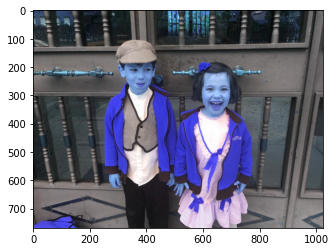

In [22]:
detect_face_eyes_smile(dir_demo)

In [24]:
pink = [255, 153, 255]

In [25]:
orange = [255, 128, 0]

In [26]:
red = [255, 0, 0]

In [27]:
bright_green = [0, 255, 0]

<ipython-input-23-7b98b03e07b0>:6: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  rgb_image = color.label2rgb(label_image)


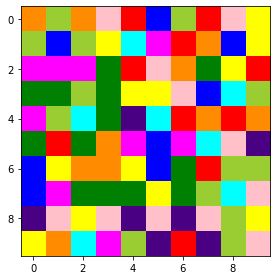

In [23]:
from skimage import color,io
import numpy as np
from skimage import color, io

label_image = np.random.randint(100, size=(10, 10))
rgb_image = color.label2rgb(label_image)

io.imshow(rgb_image)
io.show()
            
            
            

# FUNCTION ONE

In [ ]:
def openImageAndDetectFaces3(paaath):
    
    for file in sorted(paaath.iterdir()):
        
        if file.suffix == '.jpg':
            
            image = face_recognition.load_image_file(file)
            face_locations = face_recognition.face_locations(image)
            count = 0
            
            try:
                #print(f"I found {len(face_locations)} face(s) in photograph {file.name}.")
                #plt.subplot(121)
                #plt.imshow(image)
                
                for feis in face_locations:
                    count+=1
                    top, right, bottom, left = feis
                    face_image = image[top:bottom, left:right]
                    face_image = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
                    pil_image = Image.fromarray(face_image)
                    reshaped_image = modify_size(pil_image)

                    file_face = file.name.replace(".",f"_face{count}.")
                    file_pil = file.name.replace(".",f"_pil{count}.")
                    file_reshaped = file.name.replace(".",f"_reshaped{count}.")
                    cv2.imwrite(str(folder_faces/file_face), face_image)
                    
                    #fig, axarr = plt.subplots(len(face_locations),1)
                    #plt.subplot(121)
                    #plt.imshow(new_size(pil_image))
                    #f.name.replace(".",f"_face{count}.")
                    #cv2.imwrite(str(folder_faces/file_pil), pil_image)
                    #cv2.imwrite(str(folder_faces/file_reshaped), reshaped_image)
                    #cv2.imwrite(str(folder_faces/file.name)+f"_face{count}", face_image)
                    #return new_size(pil_image)
            
            except ValueError as e:
                print(f"No face found")
                
    return reshaped_image

        
def modify_size(img):
    size=(48,48)
    convert_from = img.resize(size)
    face=np.asarray(convert_from)/255
    return face

In [ ]:
face = openImageAndDetectFaces3(folder_imgs)

In [ ]:
os.system('say -v Jorge Ya he terminado');

# FUNCTION TWO

In [ ]:
image_col = Image.open(pth)
image_blues = cv2.imread(pth)
image_greens = cv2.cvtColor(image_blues, cv2.COLOR_BGR2GRAY)


In [ ]:
plt.imshow(image_col)

In [ ]:
image = cv2.imread(pth)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# now we can try to detect faces
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    #flags = cv2.CASCADE_SCALE_IMAGE
)

for feis in faces:
    print(feis)
# Draw a rectangle around the faces and display on screen
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        #cv2.imshow("Faces found", image)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    #print(flags)
        #cv2.resize

### FUNCTION TWO-A ¿?

In [ ]:
plt.imshow(image_blues)

In [ ]:
print(type(image_blues))
print('len(image_blues): ',len(image_blues))
print('image_blues.shape: ',image_blues.shape)
print('len(image_blues)[0]: ',len(image_blues[0]))
print('image_blues[0]: ',image_blues[0])
print('image_blues[0][0]: ',image_blues[0][0])

In [ ]:
faces_blue = face_cascade.detectMultiScale(
    image_blues,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    #flags = cv2.CASCADE_SCALE_IMAGE
)

In [ ]:
print(type(faces_blue))
print('len(faces_blue): ',len(faces_blue))
print('faces_blue.shape: ',faces_blue.shape)
print('len(faces_blue)[0]: ',len(faces_blue[0]))
print('faces_blue[0]: ',faces_blue[0])
print('faces_blue: ',faces_blue)

In [ ]:
for (x, y, w, h) in faces_blue:
    rec_blue = cv2.rectangle(image_blues, (x, y), (x+w, y+h), (0, 255, 0), 2)
    print(rec_blue[0])
    print(rec_blue.shape)

In [ ]:
aux_blue = image_blues
rostro_blue = aux_blue[y:y+h,x:x+w]
rostro_blue = cv2.resize(rostro_blue,(150,150),interpolation=cv2.INTER_CUBIC)

In [ ]:
rostro_blue.shape

In [ ]:
plt.imshow(rostro_blue)

In [ ]:
plt.imshow(image_blues)

### FUNCTION TWO-B ¿?

In [ ]:
plt.imshow(image_greens)

In [ ]:
# GRAY = IMAGE_GREENS

In [ ]:
print(type(image_greens))
print('len(image_greens): ',len(image_greens))
print('image_greens.shape: ',image_greens.shape)
print('len(image_greens)[0]: ',len(image_greens[0]))
print('image_greens[0]: ',image_greens[0])
print('image_greens[0][0]: ',image_greens[0][0])

In [ ]:
faces_green = face_cascade.detectMultiScale(
    image_greens,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    #flags = cv2.CASCADE_SCALE_IMAGE
)

In [ ]:
print(type(faces_green))
print('len(faces_green): ',len(faces_green))
print('faces_green.shape: ',faces_green.shape)
print('len(faces_green)[0]: ',len(faces_green[0]))
print('faces_green[0]: ',faces_green[0])
print('faces_green: ',faces_green)

In [ ]:
for (x, y, w, h) in faces_green:
    rec_green = cv2.rectangle(image_greens, (x, y), (x+w, y+h), (0, 255, 0), 2)
    print(rec_green)
    print(rec_green.shape)

In [ ]:
aux_green = image_greens
rostro_green = aux_green[y:y+h,x:x+w]
rostro_green = cv2.resize(rostro_green,(150,150),interpolation=cv2.INTER_CUBIC)

In [ ]:
rostro_green.shape

In [ ]:
plt.imshow(rostro_green)

In [ ]:
plt.imshow(image_greens)

### EXTRA STUFF

In [ ]:
"""
pth = "../imgs/"
file = "im14"
ext = ".jpg"
ab_pth = pth+file+ext
"""


In [ ]:
def openImageAndDetectFaces1(path):
    image = face_recognition.load_image_file(path)
    face_locations = face_recognition.face_locations(image)
    try:
        print("I found {} face(s) in this photograph.".format(len(face_locations)))
        plt.imshow(image)
        for face_location in face_locations:
            top, right, bottom, left = face_location
            face_image = image[top:bottom, left:right]
            face_image = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
            pil_image = Image.fromarray(face_image)
            #plt.imshow(pil_image)
            fig, axarr = plt.subplots(len(face_locations),1)
            plt.subplot(121)
            plt.imshow(modify_size(pil_image))
        #return modify_size(pil_image)
    except ValueError as e:
        print(f"No face found")
        
        
def modify_size(img):
    size=(48,48)
    convert_from = img.resize(size)
    face=np.asarray(convert_from)/255
    return face

In [ ]:
face = openImageAndDetectFaces1(pth)

In [ ]:
pth = "../imgs/"
file = "im_10"
ext = ".jpg"
ab_pth = pth+file+ext

def openImageAndDetectFaces2(ab_pth):
    
    image = face_recognition.load_image_file(ab_pth)
    face_locations = face_recognition.face_locations(image)
    count = 0
    try:
        print("I found {} face(s) in this photograph.".format(len(face_locations)))
        #plt.subplot(121)
        plt.imshow(image)
        for feis in face_locations:
            count+=1
            top, right, bottom, left = feis
            face_image = image[top:bottom, left:right]
            face_image = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
            pil_image = Image.fromarray(face_image)
            fig, axarr = plt.subplots(len(face_locations),1)
            #plt.subplot(121)
            #plt.imshow(image)
            plt.subplot(121)
            plt.imshow(new_size(pil_image))
            #image_name = os.path.join(subfolder, '{:05d}.jpg'.format(i))
            #im.save(image_name)
            #print(pil_image)
            face_in_pic_pth = pth+file+f"_face{count}"+ext
            cv2.imwrite(face_in_pic_pth, face_image)
            print(face_in_pic_pth)
            #return new_size(pil_image)
    except ValueError as e:
        print(f"No face found")
        return pil_image
     
        
def new_size(img):
    size=(48,48)
    convert_from = img.resize(size)
    face=np.asarray(convert_from)/255
    return face

In [ ]:
face = openImageAndDetectFaces2("../imgs/im_10.jpg")

In [ ]:
# NOT DONE
def openImageAndDetectFaces_HAAS(paaath):
    for file in sorted(paaath.iterdir()):
        if file.suffix == '.jpg':
            count = 0
            
            image = face_recognition.load_image_file(file)
            face_locations = face_recognition.face_locations(image)
            
            
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            auxFrame = img.copy()
            
            try:
                #print(f"I found {len(face_locations)} face(s) in photograph {file.name}.")
                #plt.subplot(121)
                #plt.imshow(image)
                
                # PRIMER APPROACH
                
                for feis in face_locations:
                    count+=1
                    top, right, bottom, left = feis
                    face_image = image[top:bottom, left:right]
                    face_image = cv2.cvtColor(face_image, cv2.COLOR_RGB2GRAY)
                     
                    jeanchas_gray = face_image.copy()
                    jeanchas_faces = face_cascade.detectMultiScale(gray,1.3,5)
                    
                    for (x,y,w,h) in jeanchas_faces:
                        cv2.rectangle(file, (x, y), (x+w, y+h), (0, 255, 0), 2)
                        rostro = auxFrame[y:y+h,x:x+w]
                        rostro = cv2.resize(rostro,(150,150),interpolation=cv2.INTER_CUBIC)
                        file_rostro = file.name.replace(".",f"_rostro{count}.")
                        cv2.imwrite(str(folder_faces/file_rostro), rostro)
                    
                    
                    
                    
                    pil_image = Image.fromarray(face_image)
                    reshaped_image = modify_size(pil_image)
                    #fig, axarr = plt.subplots(len(face_locations),1)
                    #plt.subplot(121)
                    #plt.imshow(new_size(pil_image))
                    f.name.replace(".",f"_face{count}.")
                    file_face = file.name.replace(".",f"_face{count}.")
                    cv2.imwrite(str(folder_faces/file_face), face_image)
                    
                    file_pil = file.name.replace(".",f"_pil{count}.")
                    file_reshaped = file.name.replace(".",f"_reshaped{count}.")
                    
                    
                    file_rostro = file.name.replace(".",f"_rostro{count}.")
                    cv2.imwrite(str(folder_faces/file_rostro), rostro)
                    #cv2.imwrite(str(folder_faces/file_pil), pil_image)
                    #cv2.imwrite(str(folder_faces/file_reshaped), reshaped_image)
                    #cv2.imwrite(str(folder_faces/file.name)+f"_face{count}", face_image)
                
                # SEGUNDO APPROACH
                
                for (x,y,w,h) in file:
                    x,y,w,h = rostro2
                    cv2.rectangle(file, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    
                    rostro = auxFrame[y:y+h,x:x+w]
                    rostro = cv2.resize(rostro,(150,150),interpolation=cv2.INTER_CUBIC)
                    file_rostro = file.name.replace(".",f"_rostro{count}.")
                    cv2.imwrite(str(folder_faces/file_rostro), rostro)
                    
                    #return new_size(pil_image)
            except ValueError as e:
                print(f"No face found")
                
    return reshaped_image

        
def modify_size(img):
    size=(48,48)
    convert_from = img.resize(size)
    face=np.asarray(convert_from)/255
    return face

In [ ]:
openImageAndDetectFaces_HAAS(folder_imgs)